# Projet TSA

### Imports

In [ ]:
import msicpe
print(msicpe.__version__)

from msicpe import tsa
import cv2
import numpy as np
import pandas as pd
from plotly import express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import struct
from scipy import signal
from scipy.fftpack import fft
from scipy.linalg import toeplitz
import matplotlib.pyplot as plt
from scipy.signal import convolve

*On rappelle que la documentation de la bibliothèque msicpe peut être trouvée en ligne --> __[msicpe](https://cpe.pages.in2p3.fr/msi/toolbox/msicpe.tsa.html)__.*

## Séance 1 - MDFB

### Chargement des données


In [118]:
fileName = 'AURA_rayonnement-solaire-vitesse-vent-tri-horaires-regionaux.csv'
Fs, s =  msicpe.tsa.load_signal(fileName, dataKey="Vitesse du vent à 100m (m/s)")

In [122]:
# propriétés du signal
N = len(s)           # nombre de points du signal s
D = N/Fs            # durée du signal s
# vecteur temps
ts = np.linspace(0,D,N)

In [ ]:
# affichage du signal s
df_s = pd.DataFrame({'x': ts , 'y': s , 'legende':'s'})
fig1 = px.line(df_s, x='x',  y='y', color='legende', labels={'x':'Temps (s)', 'y':''}, title='Signal temporel', width=700 )
fig1.show()

### Binarisation

In [65]:
# signal binarisé
dtype = 'int8'
sb = msicpe.tsa.data2bin(s,dtype)
# vecteur temps correspondant
d_bin =  10     # frequence d'echantillonnage du signal binaire
tb = np.linspace(0,(1/d_bin)*N*8,N*8)

In [ ]:
# Affichage de s_b 
df_sb = pd.DataFrame({'x': tb , 'y': sb , 'legende': 'signal binarisé' })
fig2 = px.line(df_sb,x='x',  y='y', color='legende', markers="*", labels={'x': 'signal binarisé' , 'y':'temps'}, title= 'signal binarié' , width=700 )
fig2.show()

### Modulation

In [67]:
# paramètres de modulation
A   = 5
nu0 = 20
nu1 = 40

# vecteur des instants d’échantillonnage du signal modulé s_m
nu_mod = 1000
T_mod  =  1/nu_mod
N_mod  = int(1/(T_mod*d_bin))

tm = np.linspace(0,T_mod*N*8*N_mod,N*8*N_mod)

# signal modulé
sm = []
k = np.linspace(0,N_mod,N_mod)
S0 = A*np.cos(2*np.pi*nu0*k*T_mod)
S1 = A*np.cos(2*np.pi*nu1*k*T_mod)
for i in range(N*8):
    if sb[i] == 0:
        sm = np.concatenate((sm,S0))
    else:
        sm = np.concatenate((sm,S1))

In [ ]:
# Affichage de s_m
df_sm = pd.DataFrame({'x': tm , 'y': sm , 'legende': ... })
fig3 = px.line(df_sm,x='x',  y='y', color='legende', labels={'x': 'tm' , 'y':'sm'}, title='signal modulé' , width=700 )
fig3.show()

### Affichages

In [ ]:
# Affichage de s_b et s_m sur une seule figure
df_signals = pd.concat([df_sm,df_sb])
fig4 = px.line(df_signals, x='x',  y='y', color='legende', labels={'x':'Temps (s)', 'y':''}, title='Comparaison de sb et sm', width=700 )
fig4.show()

## Séance 2 - Estimation de la Densité De Probabilité (DDP)

### Analyses _in-silico_

In [70]:
## Fonction de calcul d'histogramme
def histo(x,N=None,M=None):
    if M == None:        
        Delta = 3.49*np.std(x)*len(x)**(-1/3)
        M = int((max(x)-min(x))/Delta)
    else :
        Delta = (max(x)-min(x))/M

    if N == None:
        N = len(x)
    else:   
        x = x[0:N-1]

    DDPest,abcisses = np.histogram(x, bins=M,density=True)
    c = (abcisses[:-1]+abcisses[1:])/2
    return DDPest, c, Delta,N

## Foncton d'affichage
def compareDDP(c, DDPest, DDPth, std, title):
    df_DDP_th_mean      = pd.DataFrame({'x': c ,  'y': DDPth,         'legende':'DDP_th',    'line_dash':'solid','color':'red'})
    df_DDP_th_plus_std  = pd.DataFrame({'x': c ,  'y': DDPth + std ,  'legende':'DDP_th+std','line_dash':'dash', 'color':'black'})
    df_DDP_th_minus_std = pd.DataFrame({'x': c ,  'y': DDPth - std,   'legende':'DDP_th-std','line_dash':'dash', 'color':'black'})
    df_DDP_th=pd.concat([df_DDP_th_mean,df_DDP_th_plus_std,df_DDP_th_minus_std])
    
    fig = px.line(df_DDP_th, x='x',  y='y', title=title,
                  color='legende', color_discrete_sequence=['orangered','black','black'], 
                  line_dash='legende', line_dash_sequence=['solid', 'dash', 'dash'])
    fig.add_bar(x=c, y=DDPest, marker_color='gray', name="DDP estimée")
    fig.show()

In [ ]:
# analyse du canal test
b = tsa.canal_test(filtered = True)
DDPest, c, Delta,N = histo(b)
DDPth = (1/np.sqrt(2*np.pi))*np.exp(-c**2/2)
std = np.sqrt((1-DDPth)*DDPth/(Delta*N))
compareDDP(c, DDPest, DDPth, std, title=None)

#### Influence de N

In [ ]:
M=20
biais = []
variance = []
N_variable= [100, 1000, 10000,0]
for i in N_variable:
    DDPest, c, Delta,N = histo(b,i,M)
    DDPth = (1/np.sqrt(2*np.pi))*np.exp(-c**2/2)
    std = np.sqrt((1-DDPth)*DDPth/(Delta*N))
    compareDDP(c, DDPest, DDPth, std,title = 'Comparaison des DDP pour N ='+str(N)+ 'et M ='+str(M))
    
    # Calcul du biais et de la variance
    biais.append(np.mean(DDPest - DDPth))
    variance.append(np.var(DDPest))

# Affichage des résultats dans un tableau avec N colonnes
results = pd.DataFrame({
'N': N_variable,
'Biais': biais,
'Variance': variance
})
display(results)

#### Influence de $\Delta$

In [ ]:
M=[]
biais = []
variance = []
N=1000
MVariable = [5, 10,20,50,100]
for i in MVariable:
    DDPest, c, Delta,N = histo(b,N,i)
    DDPth = (1/np.sqrt(2*np.pi))*np.exp(-c**2/2)
    std = np.sqrt((1-DDPth)*DDPth/(Delta*N))
    compareDDP(c, DDPest, DDPth, std,title = 'Comparaison des DDP pour N ='+str(N)+ 'et M ='+str(i))
    
    # Calcul du biais et de la variance
    biais.append(np.mean(DDPest - DDPth))
    variance.append(np.var(DDPest))

# Affichage des résultats dans un tableau avec N colonnes
results = pd.DataFrame({
'N': MVariable,
'Biais': biais,
'Variance': variance
})
display(results)


### Analyses _in-situ_

In [102]:
# analyse du canal de transmission réel
canal_id = 1
X = tsa.transmit(sm*0, canal_id)
DDPest, c, Delta,N = histo(X)
DDPth = (1/np.sqrt(2*np.pi))*np.exp(-c**2/2)
std = np.sqrt((1-DDPth)*DDPth/(Delta*N))
compareDDP(c, DDPest, DDPth, std, title="DDP estimée et théorique pour le canal de transmission n°"+str(canal_id))

## Séance 3 - Estimation de la Densité Spectrale de Puissance Moyenne

### Analyses _in-silico_

In [103]:
def compareDSP(f,fth,DSPth,DSPbiais,DSPest,title):
   graphe_DSPth      = pd.DataFrame({'x': fth ,  'y': DSPth,         'legende':'DSPth',    'line_dash':'solid','color':'red'})
   graphe_DSPbiais  = pd.DataFrame({'x': fth ,  'y': DSPbiais,  'legende':'DSPbiais','line_dash':'dash', 'color':'blue'})
   graphe_DSPest = pd.DataFrame({'x': f ,  'y':10*np.log10(DSPest),   'legende':'DSPest','line_dash':'dash', 'color':'black'})
   df_DSP_th=pd.concat([graphe_DSPth,graphe_DSPbiais,graphe_DSPest])
    
   fig = px.line(df_DSP_th, x='x',  y='y', title=title,
               color='legende', color_discrete_sequence=['orangered','blue','black'], 
               line_dash='legende', line_dash_sequence=['solid', 'dash', 'dash'])
   fig.update_xaxes(range=[0,0.5])
   fig.show()

##### Estimateur spectral simple

In [104]:
def estimateur_simple(x, nd, N, nfft):
    DSPest1 = np.abs(np.fft.fft(x[nd:N+nd],nfft))**2 / N
    f = np.linspace(0, nfft-1, nfft)/nfft
    return DSPest1,f

##### Estimateur spectral moyenné

In [105]:
def estimateur_moyenne(x, M, nfft):
    f,DSPest2 = signal.welch(x,nperseg = M,noverlap=0,nfft = nfft)
    return DSPest2,f

##### Estimateur spectral de Welch

In [106]:
def estimateur_welch(x, window, M, Noverlap, nfft):
    f, DSPest3 = signal.welch(x, window=window, nperseg=M, noverlap=Noverlap, nfft=nfft)
    return DSPest3, f

### Analyses _in-situ_

In [107]:
N = 2048
nd = 0
nfft = 1024
M = 1024
DSP1est,f = estimateur_simple(X, nd, N, nfft)
DSPth1, DSPbiais1,fth1 = tsa.sptheo(N,'simple')
compareDSP(f,fth1,DSPth1,DSPbiais1,DSP1est,"Compare DSP simple")

DSP2est,f = estimateur_moyenne(X,M, nfft)
DSPth2, DSPbiais2,fth2 = tsa.sptheo(M,'moyenne')
compareDSP(f,fth2,DSPth2,DSPbiais2,DSP2est,"Compare DSP moyenne")

DSP3est,f = estimateur_welch(x=X,window='hann',M=M,Noverlap=1000, nfft=nfft)
DSPth3, DSPbiais3,fth3 = tsa.sptheo(Q=M,method='welch',fenetre='hann')
compareDSP(f,fth3,DSPth3,DSPbiais3,DSP3est,"Compare DSP welch")


## Séance 4 - Détection d’un signal noyé dans un bruit

In [108]:
# Transmission
powB = 4 # puissance du bruit
sm_tr = tsa.transmit(sm, canal_id, powB)
'''df_sm_tr = pd.DataFrame({'x': tm , 'y': sm_tr , 'legende':'s'})
fig1 = px.line(df_sm_tr, x='x',  y='y', color='legende', labels={'x':'Temps (s)', 'y':''}, title='Signal temporel', width=700 )
fig1.show()'''

"df_sm_tr = pd.DataFrame({'x': tm , 'y': sm_tr , 'legende':'s'})\nfig1 = px.line(df_sm_tr, x='x',  y='y', color='legende', labels={'x':'Temps (s)', 'y':''}, title='Signal temporel', width=700 )\nfig1.show()"

#### Débruitage par détection

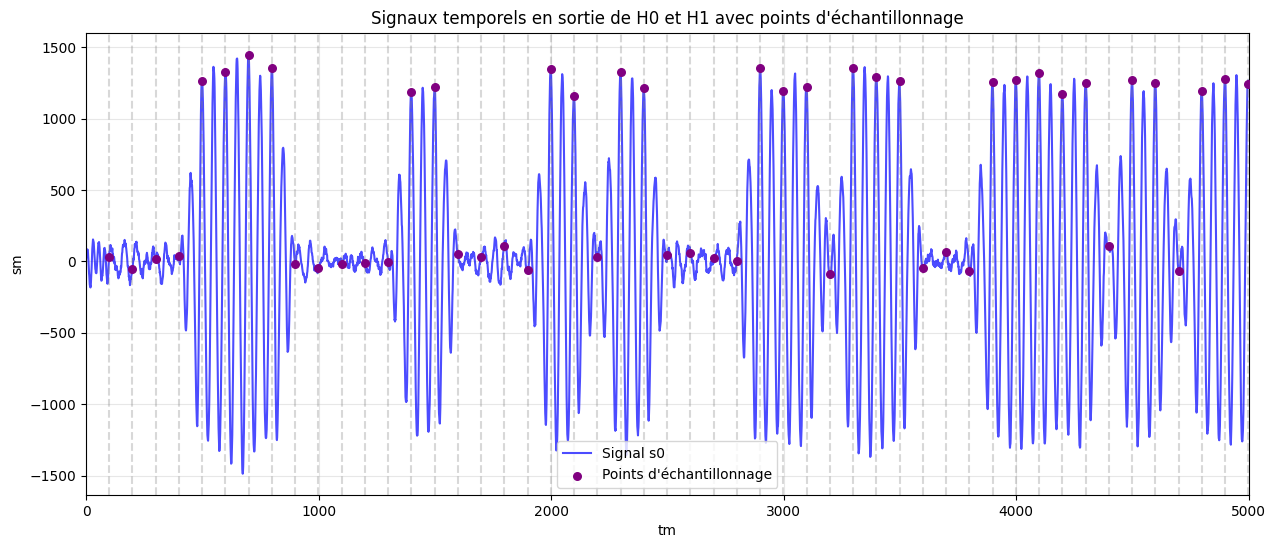

In [109]:
Npoint = 8*N*N_mod + N_mod - 1
th = np.linspace(0,1-1/Npoint,Npoint) # vecteur temps d'un symbole

NFFT = N_mod + len(sm_tr) -1
TFS0 = np.fft.fft(S0,NFFT)
TFS1 = np.fft.fft(S1,NFFT)
DSP = 1

# reponses impulsionnelles des filtres de détection
H0 = TFS0/DSP                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
H1 = TFS1/DSP
# signaux en sortie des 2 filtres
s0 = np.fft.ifft(H0 *np.fft.fft(sm_tr,NFFT),NFFT).real
s1 = np.fft.ifft(H1 *np.fft.fft(sm_tr,NFFT),NFFT).real  
sd = np.zeros(len(sb), dtype=int) #tableau de zero dans lequel je vais mettre les points de mes signaux

for i in range(len(sb)) : 
    center = int((i+1)*N_mod-1) #Centrer chaque periode T_mod
    if s1[center]>s0[center] :
        sd[i] = 1
    else : 
        sd[i] = 0

sd = sd.astype(int)
# Calcul des centres
centres = [int((i+1)*N_mod-1)for i in range(int((len(s0)-100)/N_mod)+1)]
# Filtrer les centres dans la plage [0,5000]
centres_filtered = [c for c in centres if 0 <= c <= 5000]

plt.figure(figsize=(15, 6))

# Tracer les signaux s0 et s1
plt.plot(range(0, 5000), s0[0:5000], label='Signal s0', color='blue', alpha=0.7)

# Tracer les points d'échantillonnage
plt.scatter(centres_filtered, s0[centres_filtered], color='purple', 
           label='Points d\'échantillonnage', zorder=5, s=30)

# Ajouter des lignes verticales aux points d'échantillonnage
for centre in centres_filtered:
    plt.axvline(x=centre, color='gray', linestyle='--', alpha=0.3)

plt.title('Signaux temporels en sortie de H0 et H1 avec points d\'échantillonnage')
plt.xlabel('tm')
plt.ylabel('sm')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 5000)

plt.show()

#### Étude de l’effet du bruit de transmission sur la précision

In [110]:
def error(sd,sb):
    count = 0
    for i in range(len(sd)):
        if sd[i] != sb[i]:
            count +=1   
    print(count)
    return (count)/len(sd)*100

#### Décodage

In [111]:
sd = sd.astype(np.uint8)
s_tr = tsa.bin2data(sd,'uint8')
s_tr = np.packbits(sd).astype(np.int8)
df_s = pd.DataFrame({'x': ts , 'y': s , 'legende':'s'})
df_s_tr = pd.DataFrame({'x': ts, 'y': s_tr , 'legende':'s_tr'})
df_signals = pd.concat([df_s_tr,df_s])
fig4 = px.line(df_signals, x='x',  y='y', color='legende', labels={'x':'Temps (s)', 'y':''}, title='Comparaison de s et s_tr', width=700 )
fig4.show()


## Séance 5 - Prédiction AR d’ordre $\textit{M}$

#### Estimation de la fonction d’autocorrélation

In [112]:

K = 200
Gam = signal.correlate(s_tr.astype(np.float32), s_tr.astype(np.float32), mode='full', method='auto')
Gam /= len(s_tr)
Gam = Gam[len(Gam)//2 - K:len(Gam)//2 + K + 1]
lags = signal.correlation_lags(len(s_tr), len(s_tr), mode="full")
lags = lags[len(lags)//2 - K:len(lags)//2 + K + 1]
df_Gam = pd.DataFrame({'x':  lags, 'y': Gam , 'legende':'s'})
fig1 = px.line(df_Gam, x='x',  y='y', color='legende', labels={'x':'lags', 'y':''}, title='Gam lags', width=700 )
fig1.show()




#### Identification du modèle AR(M)

In [113]:
M = 56
# matrice du systeme lineaire
G = toeplitz(Gam[K:K+M+1])
b = np.zeros(M+1)
b[0] = 1
# solution du systeme G.Phi = b
Phi = np.linalg.pinv(G) @ b
# coefficients du filtre de Wiener
h = -Phi/Phi[0]
#ATTENTION il reste le 1 de la premiere ligne que nous voulons enlever
# Suppression de la première ligne
h = h[1:] # Garde toutes les lignes sauf la première
# Puissance de l'erreur
sigma = 1 / Phi[0]
print(f"Puissance de l'erreur : {sigma}")
DF_h = pd.DataFrame({'x':np.linspace(0,M-1, M), 'y':h, 'legende':'h'})
fig6 = px.line(DF_h, x='x', y='y', title="Coefficients du filtre de Wiener")
fig6.show()

Puissance de l'erreur : 316.6117300710749


#### Prédiction Linéaire

In [114]:
s_hat = signal.convolve(s_tr,h, mode = "valid")
s_hat = np.concatenate((np.zeros(M),s_hat[:-1]))
ts_full = np.linspace(0,len(s)/Fs,len(s))

df_s_hat = pd.DataFrame({'x':ts_full, 'y':s_hat, 'legende':'s_hat'})
df_s = pd.DataFrame({'x':ts_full, 'y':s_tr, 'legende':'s'})
df_compare = pd.concat([df_s_hat,df_s])
fig7 = px.line(df_compare, x='x', y='y', color = 'legende', labels={'x': 'Temps (s)', 'y':''}, title="Comparaison s et s estimé")
fig7.show()


#### Restauration par filtrage causal/anti-causal

In [115]:
# Prédiction causale
s_causal = convolve(s_tr, h, mode="valid")
s_causal = np.concatenate((np.zeros(M), s_causal)) # Décalage pour alignement
# Prédiction anti-causale
h_anticausal = h[::-1] # Inversion du filtre
s_anticausal = convolve(s_tr, h_anticausal, mode="valid")
s_anticausal = np.concatenate((s_anticausal, np.zeros(M))) # Décalage pour alignement
s_causal = s_causal[:-1]
s_anticausal = s_anticausal[:-1]


epsilon_causal = s_tr - s_causal
epsilon_anticausal = s_tr - s_anticausal

df_s_hat_anticausal = pd.DataFrame({'x':ts_full, 'y':s_anticausal, 'legende':'s_hat'})
df_compare_anticausal = pd.concat([df_s_hat_anticausal,df_s])
fig9 = px.line(df_compare_anticausal, x='x', y='y', color = 'legende', labels={'x': 'Temps (s)', 'y':''}, title="Comparaison s_tr et s_anticausal")
fig9.show()

df_s_hat_causal = pd.DataFrame({'x':ts_full, 'y':s_causal, 'legende':'s_hat'})
df_compare_causal = pd.concat([df_s_hat_causal,df_s])
fig10 = px.line(df_compare_causal, x='x', y='y', color = 'legende', labels={'x': 'Temps (s)', 'y':''}, title="Comparaison s_tr et s_causal")
fig10.show()